# Feature spaces, Linear Algebra, Numeric data methods, Linear Regression
#### Part 1
1. Feature space from csv file. Read `data/ds_salaries.csv` into a pandas dataframe
2. Prune the dataset to only have columns: "work_year", "experience_level", "salary_in_usd", "job_title", "company_location", "company_size".
3. Onehot encode "experience_level". Hint: look up pandas: `get_dummies()` method.
4. labelencode "company_location"
5. Normalize the company_location number (relative value between 0-1) ![](https://cdn-images-1.medium.com/max/253/1*Dl3P3Rrzto258X0Ales9Xw.png)
6. Make binning of the salary column (both cut and qcut methods).
7. Make a barplot with binned salaries to show the company size count for each of the bins. Like this:

<img src="images/binned_salaries.jpg" width=300/>

Hint: Use pandas Series unstack() method to get a dataframe from a multiindex Series object (The result of making a groupby count on both salary_bins and company_size columns

In [8]:
import pandas as pd
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder, Normalizer

In [9]:
data = pd.read_csv("../../data/ds_salaries.csv")
df = pd.DataFrame(data)

df = df[["work_year", "experience_level", "salary_in_usd", "job_title", "company_location", "company_size"]]
df = pd.get_dummies(df, columns=["experience_level"])


In [10]:
le = LabelEncoder()
nm = Normalizer()

df["company_location"] = le.fit_transform(df["company_location"])

#df_company_normalized = nm(df["company_location"])
df["company_location"]

0      12
1      29
2      18
3      20
4      48
       ..
602    48
603    48
604    48
605    48
606    48
Name: company_location, Length: 607, dtype: int64

In [11]:
bins = [0, 75000, 120000, 250000, 600000]
labels = ["S", "M", "L", "XL"]
df_copy = df.copy()

df_copy["binned_salary"] = pd.cut(df_copy["salary_in_usd"], bins=bins, labels=labels)
df_copy.head()

df_copy.groupby()



TypeError: You have to supply one of 'by' and 'level'

In [12]:
df_copy["binned_salary_qcut"] = pd.qcut(df_copy["salary_in_usd"], [0, 0.25, 0.50, 0.75, 1.0])
df_copy.head()


,work_year,salary_in_usd,job_title,company_location,company_size,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,binned_salary,binned_salary_qcut
0,2020,79833,Data Scientist,12,L,0,0,1,0,M,"(62726.0, 101570.0]"
1,2020,260000,Machine Learning Scientist,29,S,0,0,0,1,XL,"(150000.0, 600000.0]"
2,2020,109024,Big Data Engineer,18,M,0,0,0,1,M,"(101570.0, 150000.0]"
3,2020,20000,Product Data Analyst,20,S,0,0,1,0,S,"(2858.999, 62726.0]"
4,2020,150000,Machine Learning Engineer,48,L,0,0,0,1,L,"(101570.0, 150000.0]"


<AxesSubplot: xlabel='binned_salary'>

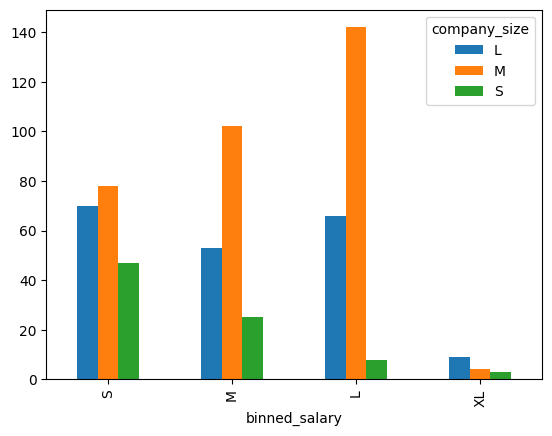

In [13]:
d = df_copy.groupby(["binned_salary", "company_size"]).size()
u = d.unstack()
u.plot.bar()


#### Part 2
8. Make it into a function that can take either company_size or experience_level as arguments.
9. Change the experience_level column to be numeric using this dictionary: `experience = {'EN':10,'EX':20,'MI':30,'SE':40}`. Hint: [Here](https://sparkbyexamples.com/pandas/pandas-remap-values-in-column-with-a-dictionary-dict/).
10. Use seaborn pairplot to see if there is an approximately linear relationship between experience_level and salary*
11. scatter Plot the 2d feature space of 'experience_level' and 'salary_in_usd
12. Use sklearn to find the best possible linear relationship between experience_level and salary_in_usd using linear regression.

In [23]:
def task_8(company_size: int = None, experience_level: int = None):
    local_data = pd.read_csv("../../data/ds_salaries.csv")
    local_df = pd.DataFrame(local_data)

    if company_size:
        _data = local_df.loc[local_data["company_size"] == company_size]
        _data["cut"] = pd.cut(_data["salary_in_usd"], bins=5)
        return _data['cut'].value_counts().tolist()
    elif experience_level:
        _data = local_data.loc[["experience_level"] == experience_level]
        _data["cut"] = pd.cut(_data["salary_in_usd"], bins=5)
        return _data['cut'].value_counts().tolist()
    else:
        return None

experience = {'EN':10,'EX':20,'MI':30,'SE':40}
exp_en_salary = task_8(experience_level=experience.get("EN"))
exp_ex_salary = task_8(experience_level=experience.get("EX"))
exp_mi_salary = task_8(experience_level=experience.get("MI"))
exp_se_salary = task_8(experience_level=experience.get("SE"))

plot_df = pd.DataFrame({experience[0]: exp_en_salary,
                        experience[1]: exp_ex_salary,
                        experience[2]: exp_mi_salary,
                        experience[3]: exp_se_salary}, index=["EN", "EX", "MI", "SE"])


KeyError: 'False: boolean label can not be used without a boolean index'

## Part 3: Linear Algebra
Given the below dictionarys find out where each of the 4 people find the cheapest shopping according to their needs.
```python
shoppers = {
'Paula':{'Is':4,'Juice':2,'Kakao':3,'Lagkager':2},
'Peter':{'Is':2,'Juice':5,'Kakao':0, 'Lagkager':4},
'Pandora':{'Is':5,'Juice':3, 'Kakao':4, 'Lagkager':5},
'Pietro':{'Is':1,'Juice':8, 'Kakao':9, 'Lagkager':1}
}
shop_prices = {
    'Netto': {'Is':10.50,'Juice':2.25,'Kakao':4.50,'Lagkager':33.50},
    'Fakta': {'Is':4.00,'Juice':4.50,'Kakao':6.25,'Lagkager':20.00}
}
```
Hint: you can use pandas and Transpose to create dataframe: `pd.DataFrame(shoppers).T` to get the necessary shape of the dataframe/matrix. Also use df.to_numpy() to changes a Pandas DataFrame df into a numpy ndarray with only the numeric data

In [1]:
import numpy as np
import pandas as pd

#Data
shoppers = {
'Paula':{'Is':4,'Juice':2,'Kakao':3,'Lagkager':2},
'Peter':{'Is':2,'Juice':5,'Kakao':0, 'Lagkager':4},
'Pandora':{'Is':5,'Juice':3, 'Kakao':4, 'Lagkager':5},
'Pietro':{'Is':1,'Juice':8, 'Kakao':9, 'Lagkager':1}
}
shop_prices = {
    'Netto': {'Is':10.50,'Juice':2.25,'Kakao':4.50,'Lagkager':33.50},
    'Fakta': {'Is':4.00,'Juice':4.50,'Kakao':6.25,'Lagkager':20.00}
}

shopper_df = pd.DataFrame(shoppers).T
prices_df = pd.DataFrame(shop_prices)
# shoppers = p
P = shopper_df.to_numpy()
Q = prices_df.to_numpy()

R = shopper_df.dot(prices_df)
# R = P.dot(Q)
print(R)

prices_1 = (4 * 10.50 + 2 * 2.25 + 3 * 4.50 + 2 * 33.50)
prices_2 = (4 * 4 + 2 * 4.50 + 3 * 6.25 + 2 * 20.00)

print(f"netto: {prices_1} fakta: {prices_2}")


          Netto   Fakta
Paula    127.00   83.75
Peter    166.25  110.50
Pandora  244.75  158.50
Pietro   102.50  116.25
netto: 127.0 fakta: 83.75
